In [ ]:
!pip install adjustText

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
project_folder = "..."
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
/content/drive/My Drive/CLL_Phd


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import auc
from matplotlib_venn import venn2

# MultiPanel

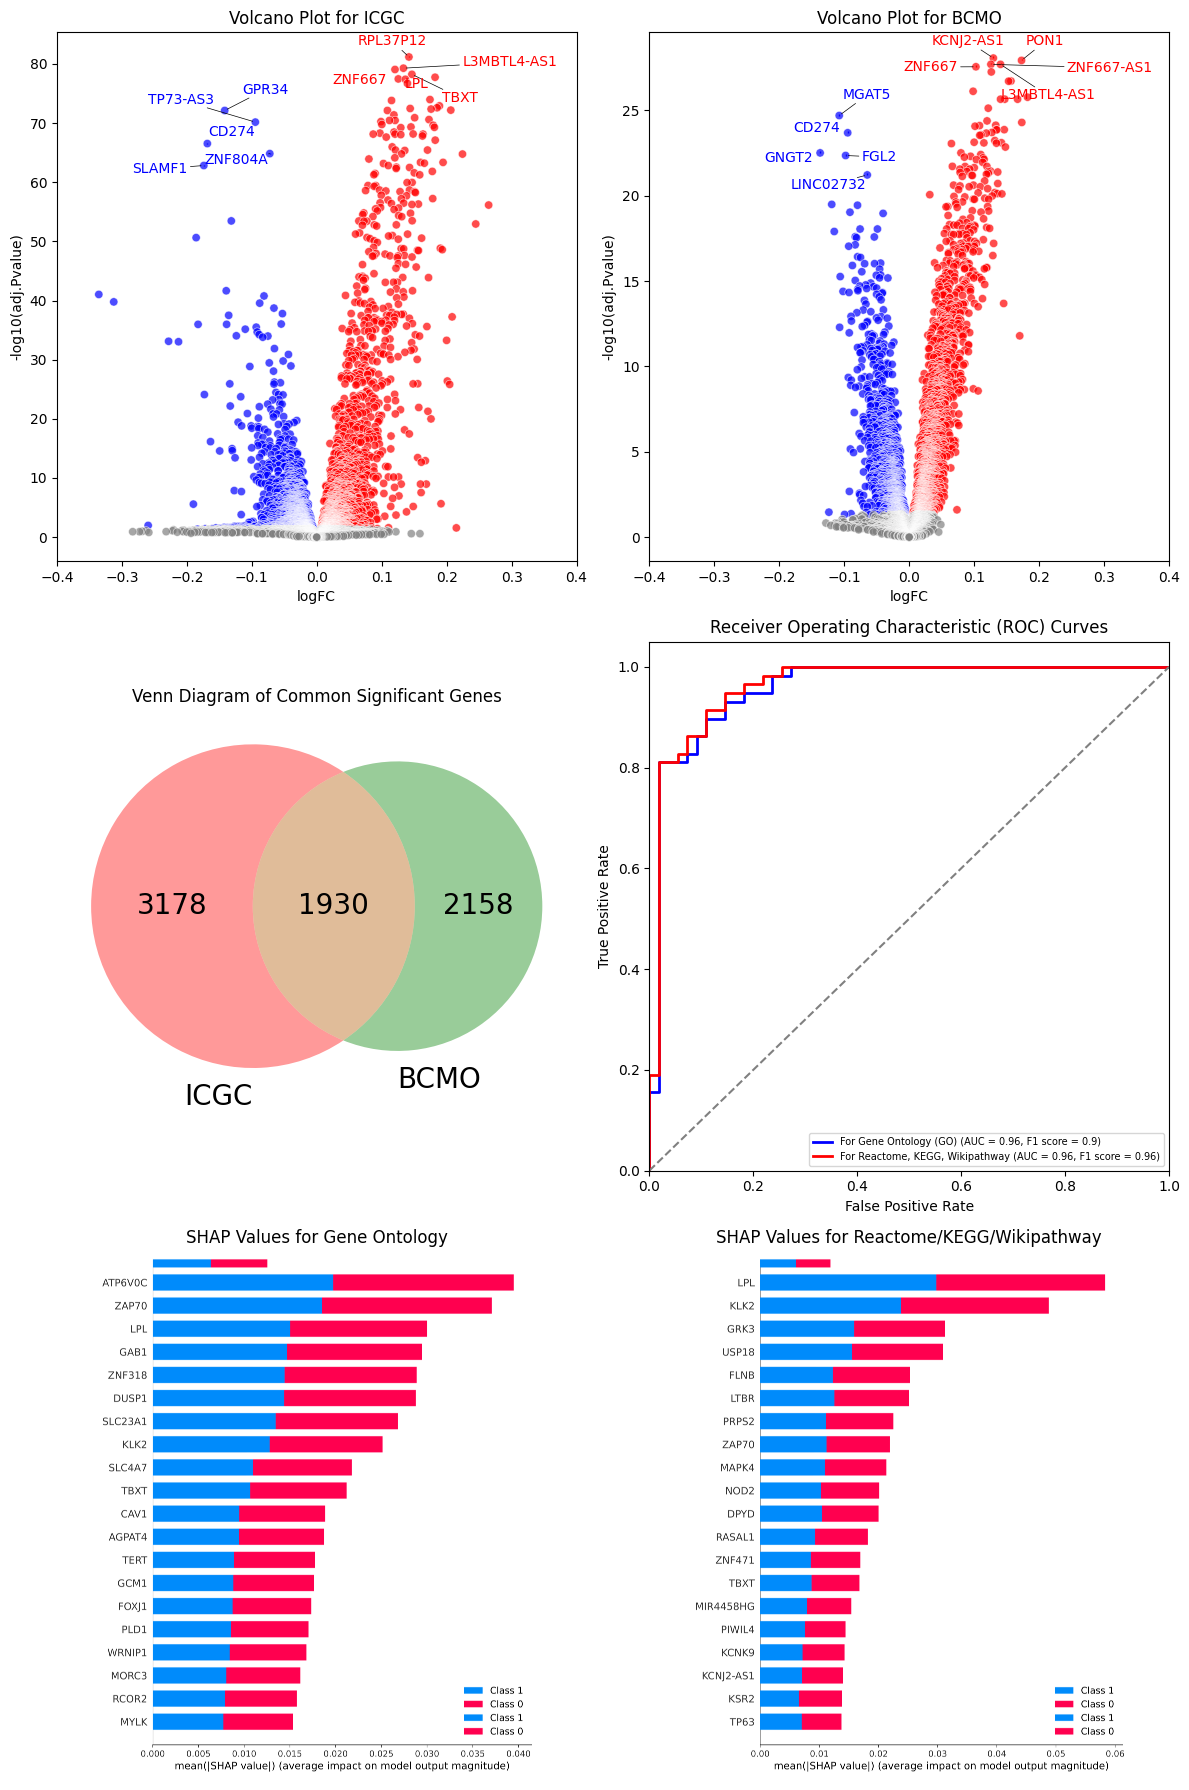

In [ ]:

from sklearn.metrics import auc
from adjustText import adjust_text
import cairosvg
import io
import matplotlib.image as mpimg

# Load dataframes
df1_vol = pd.read_excel('ICGC/results.xlsx')
df2_vol = pd.read_excel('BCMO/results.xlsx')

# Define plot functions
def plot_volcano(ax, df, title):
    df['-log10(adj_pval_DA)'] = -np.log10(df['adj_pval_DA'])

    # Define color conditions
    conditions = [
        (df['adj_pval_DA'] >= 0.05),  # Non-significant
        (df['adj_pval_DA'] < 0.05) & (df['logFC_DA'] > 0),  # Significant and upregulated (positive logFC)
        (df['adj_pval_DA'] < 0.05) & (df['logFC_DA'] < 0)   # Significant and downregulated (negative logFC)
    ]

    colors = ['grey', 'red', 'blue']

    df['color'] = np.select(conditions, colors, default='grey')

    # Plotting the volcano plot
    sns.scatterplot(x='logFC_DA', y='-log10(adj_pval_DA)', data=df, hue='color',
                    palette={'grey': 'grey', 'red': 'red', 'blue': 'blue'},
                    alpha=0.7, legend=False, ax=ax)

    # Set x-axis limits
    ax.set_xlim(-0.4, 0.4)

    # Find the top 5 most significant upregulated and downregulated genes
    top_pos_genes = df[df['logFC_DA'] > 0].nlargest(5, '-log10(adj_pval_DA)')
    top_neg_genes = df[df['logFC_DA'] < 0].nlargest(5, '-log10(adj_pval_DA)')

    # Collect text annotations and their positions
    texts = []

    for _, row in top_pos_genes.iterrows():
        texts.append(ax.text(row['logFC_DA'], row['-log10(adj_pval_DA)'], row['ID'],
                             fontsize=10, ha='left', color='red'))
        # Draw line to the text
        ax.plot([row['logFC_DA'], row['logFC_DA']],
                [row['-log10(adj_pval_DA)'], row['-log10(adj_pval_DA)'] + 0.1],
                color='red', linestyle='--', linewidth=1)

    for _, row in top_neg_genes.iterrows():
        texts.append(ax.text(row['logFC_DA'], row['-log10(adj_pval_DA)'], row['ID'],
                             fontsize=10, ha='right', color='blue'))
        # Draw line to the text
        ax.plot([row['logFC_DA'], row['logFC_DA']],
                [row['-log10(adj_pval_DA)'], row['-log10(adj_pval_DA)'] + 0.1],
                color='blue', linestyle='--', linewidth=1)

    # Adjust the positions of the text annotations
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='black', lw=0.5), force_text=(0.2, 0.3),  # Increase repelling force between texts
    force_explode=(0.2, 0.4))

    # Add title and labels
    ax.set_title(title)
    ax.set_xlabel('logFC')
    ax.set_ylabel('-log10(adj.Pvalue)')

def plot_venn(ax):
    # Extract significant genes
    significant_genes_df1 = set(df1_vol[df1_vol['adj_pval_DA'] < 0.05]['ID'])
    significant_genes_df2 = set(df2_vol[df2_vol['adj_pval_DA'] < 0.05]['ID'])

    # Create Venn diagram
    venn = venn2([significant_genes_df1, significant_genes_df2],
                 ('ICGC', 'BCMO'), ax=ax)

    # Set label size
    for label in venn.set_labels:
        label.set_fontsize(20)  # Adjust size as needed

    # Set number size
    for text in venn.set_labels:
        text.set_fontsize(20)  # Adjust size as needed

    for text in venn.subset_labels:
        text.set_fontsize(20)  # Adjust size as needed

    # Add title
    ax.set_title('Venn Diagram of Common Significant Genes')

def plot_roc(ax, fpr1, tpr1, fpr2, tpr2, roc_auc1, roc_auc2):
    # Plot ROC Curve for both dataframes
    ax.plot(fpr1, tpr1, color='blue', lw=2, label=f'For Gene Ontology (GO) (AUC = {roc_auc1:.2f}, F1 score = 0.9)')
    ax.plot(fpr2, tpr2, color='red', lw=2, label=f'For Reactome, KEGG, Wikipathway (AUC = {roc_auc2:.2f}, F1 score = 0.96)')

    # Plot the diagonal line for random classifier
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')

    # Set plot limits and labels
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curves')
    ax.legend(loc='lower right', fontsize=7)
    ax.grid(False)

dc1 = pd.read_excel('BCMO/BCMO_TEST_GO.xlsx')
dc2 = pd.read_excel('BCMO/BCMO_TEST_REST.xlsx')
f1 = pd.read_csv('BCMO/PASNet_pred_0_0_GO.txt', sep=',', names=['first', 'second'])
f2 = pd.read_csv('BCMO/PASNet_pred_0_0_REST.txt', sep=',', names=['first', 'second'])

f1['combined'] = f1.values.tolist()
f2['combined'] = f2.values.tolist()

y_pred1 = np.array(list(f1.combined))
y_pred2 = np.array(list(f2.combined))

def vectorized_label(target, n_class):
    TARGET = np.array(target).reshape(-1)
    return np.eye(n_class)[TARGET]

y1 = dc1['Condition'].astype(int)
y2 = dc2['Condition'].astype(int)

y_true1 = vectorized_label(y1, 2)
y_true2 = vectorized_label(y2, 2)

# FOR GO
fpr_list = []
tpr_list = []
threshold_list = []
roc_auc_list = []
y_true = y_true1
y_pred = y_pred1

for i in range(1): # you can make this more general
    fpr, tpr, threshold = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = metrics.auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    threshold_list.append(threshold)
    roc_auc_list.append(roc_auc)

d1 = {'FPR': fpr, 'TPR': tpr}

# FOR REST
fpr_list = []
tpr_list = []
threshold_list = []
roc_auc_list = []
y_true = y_true2
y_pred = y_pred2

for i in range(1): # you can make this more general
    fpr, tpr, threshold = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = metrics.auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    threshold_list.append(threshold)
    roc_auc_list.append(roc_auc)

d2 = {'FPR': fpr, 'TPR': tpr}

df1_auc = pd.DataFrame(d1)
df2_auc = pd.DataFrame(d2)

# Extract FPR and TPR for both dataframes
fpr1 = df1_auc['FPR']
tpr1 = df1_auc['TPR']
fpr2 = df2_auc['FPR']
tpr2 = df2_auc['TPR']

# Calculate AUC for both ROC curves
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

# Convert SVG to PNG
png_go = cairosvg.svg2png(url="shap_values20_GO_BCMO.svg", dpi=1200)
png_rest = cairosvg.svg2png(url="shap_values20_rest_BCMO.svg", dpi=1200)

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# Plot volcano plots
plot_volcano(axs[0, 0], df1_vol, "Volcano Plot for ICGC")
plot_volcano(axs[0, 1], df2_vol, "Volcano Plot for BCMO")

# Plot Venn diagram
plot_venn(axs[1, 0])

# Plot ROC curves
plot_roc(axs[1, 1], fpr1, tpr1, fpr2, tpr2, roc_auc1, roc_auc2)

# Display the first SVG as an image
img_go = mpimg.imread(io.BytesIO(png_go), format='png')
axs[2, 0].imshow(img_go)
axs[2, 0].axis('off')  # Turn off axis
axs[2, 0].set_title('SHAP Values for Gene Ontology')

# Display the second SVG as an image
img_rest = mpimg.imread(io.BytesIO(png_rest), format='png')
axs[2, 1].imshow(img_rest)
axs[2, 1].axis('off')  # Turn off axis
axs[2, 1].set_title('SHAP Values for Reactome/KEGG/Wikipathway')

# Adjust layout
plt.tight_layout()

# Save the figure with 600 dpi
plt.savefig('multipanel_figure_2x3.jpg', format='jpg', dpi=600)

# Show the plot
plt.show()
